# Задача: классификация отзывов на женскую одежду (transformers)

<a href="https://colab.research.google.com/drive/1kfzvmVyqESzKHKPLzKV3cQSqZ3sFjrIg?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### импорт библиотек

In [2]:
from IPython.display import clear_output

!pip install -U accelerate
!pip install -U transformers
!pip install datasets
!pip install evaluate

clear_output()

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets
from datasets import load_dataset
import evaluate

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import pandas as pd
import random
import os

import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
sns.set(palette='Paired')
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import re
import time
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

In [5]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from tqdm.auto import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Загрузка данных

In [6]:
!wget https://github.com/lteplova/dl26_ssd/raw/2a1250dcc3b0afcaab9b4fe0397f9cd0a1b6431f/data.zip

--2024-07-24 08:26:22--  https://github.com/lteplova/dl26_ssd/raw/2a1250dcc3b0afcaab9b4fe0397f9cd0a1b6431f/data.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lteplova/dl26_ssd/2a1250dcc3b0afcaab9b4fe0397f9cd0a1b6431f/data.zip [following]
--2024-07-24 08:26:23--  https://raw.githubusercontent.com/lteplova/dl26_ssd/2a1250dcc3b0afcaab9b4fe0397f9cd0a1b6431f/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2924120 (2.8M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.79M  --.-KB/s    in 0.05s   

2024-07-24 08:26:23 (56.5 MB/s) - ‘data.zip.

In [2]:
!unzip data.zip

Archive:  data.zip
  inflating: Womens Clothing E-Commerce Reviews.csv  


Данные c [kaggle](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)

Датасет (Women's E-Commerce Clothing Reviews) содержит 23486 строк и 10 колонок, каждая строка - это отзыв пользователя и включает следующие признаки:  


**Clothing ID:** Integer Categorical variable that refers to the specific piece being reviewed.  
**Age:** Positive Integer variable of the reviewers age.  
**Title:** String variable for the title of the review.  
**Review Text:** String variable for the review body.  
**Rating:** Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.  
**Recommended IND:** Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.  
**Positive Feedback Count:** Positive Integer documenting the number of other customers who found this review positive.  
**Division Name:** Categorical name of the product high level division.  
**Department Name:** Categorical name of the product department name.  
**Class Name:** Categorical name of the product class name.  


In [7]:
reviews = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
print(reviews.shape)
reviews.head()

(23486, 11)


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### EDA

В задаче мы будем выполнять классификацию по двум целевым признакам 'Recommended IND' и 'Rating'
Recommended IND - это бинарный признак - понравился или не понравился товар (положительный или отрицательный отзыв)
Rating - это оценка товара от 1 до 5


#### баланс классов

Проверка баланса классов для 'Recommended IND' и для 'Rating'

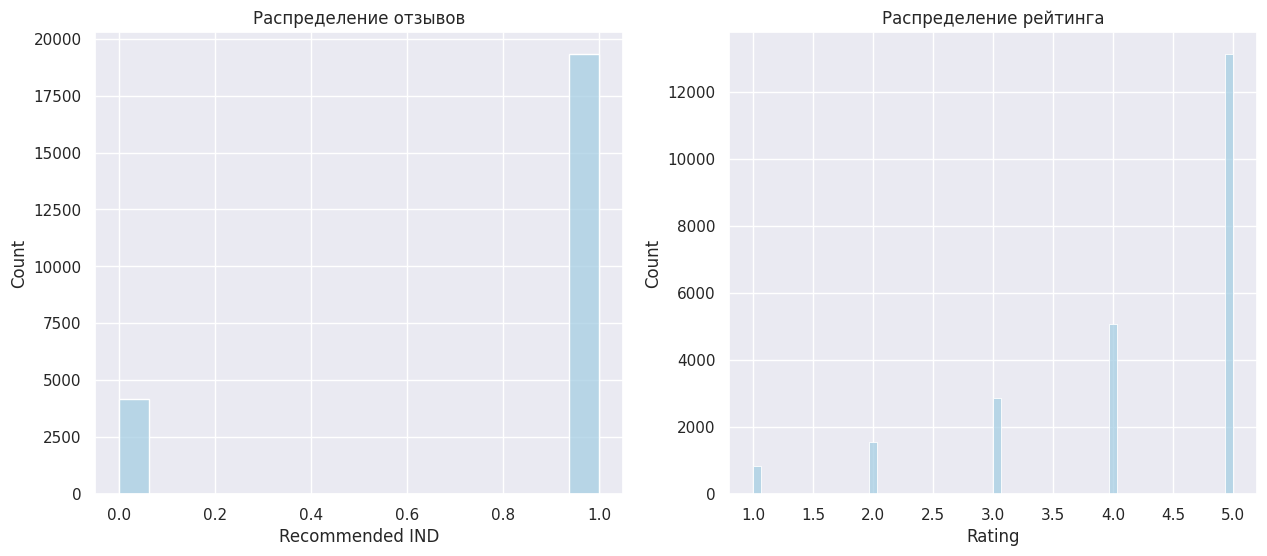

In [7]:
plt.figure(figsize = (15, 6))

plt.subplot(1, 2, 1)
sns.histplot(reviews["Recommended IND"]).set_title("Распределение отзывов");

plt.subplot(1, 2, 2)
sns.histplot(reviews["Rating"]).set_title("Распределение рейтинга");

Классы не сбалансираваны как для задачи классификации отзывов, так и для классификации по рейтингу

In [8]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [9]:
set(reviews['Recommended IND']), reviews['Recommended IND'].isnull().sum()

({0, 1}, 0)

In [10]:
# проверка количество пропусков в столбце 'Review Text' (их нужно устранить, чтобы они не мешали обучению)
reviews['Review Text'].isnull().sum()

845

In [11]:
# вывод дубликатов, мы видим, что дубликатов нет
reviews[reviews.duplicated()]

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name


In [12]:
set(reviews['Rating']), reviews['Rating'].isnull().sum()

({1, 2, 3, 4, 5}, 0)

#### распределение признаков

Посмотрим распредения по другим столбцам, чтобы лучше понять структуру данных

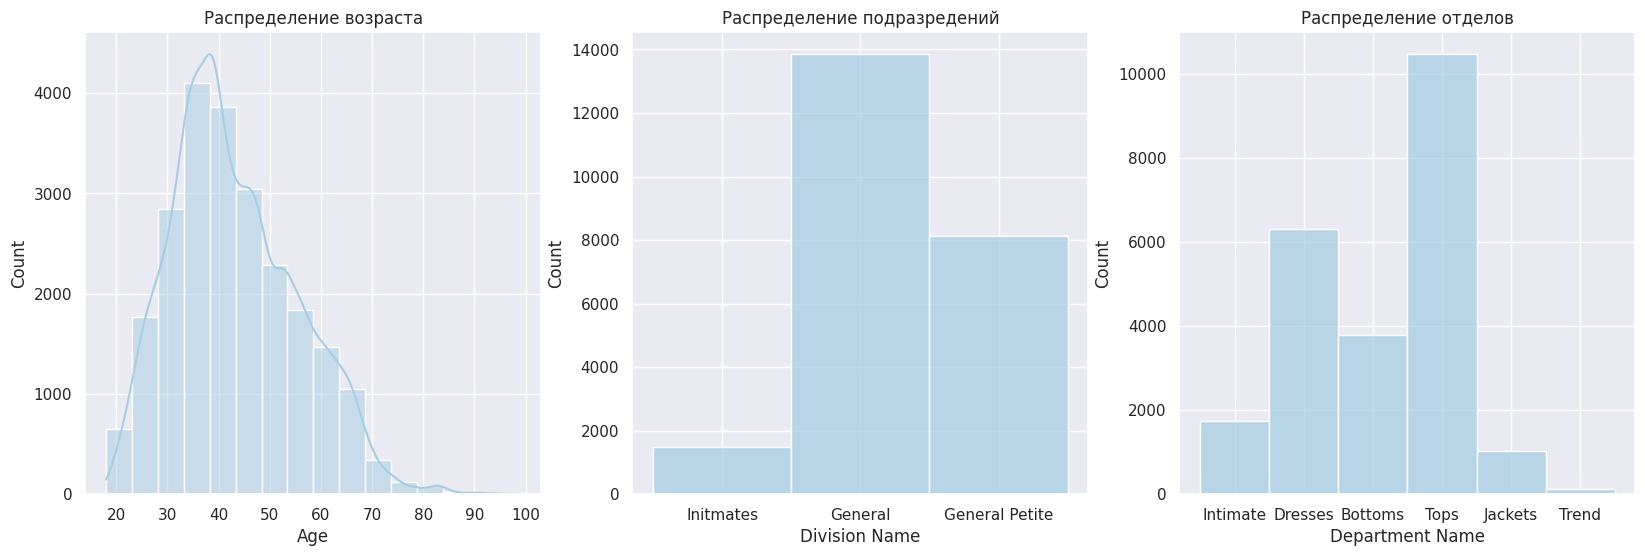

In [13]:
plt.figure(figsize = (20, 6))
plt.subplot(1, 3, 1)
sns.histplot(reviews["Age"], kde=True, binwidth=5).set_title("Распределение возраста");

plt.subplot(1, 3, 2)
sns.histplot(reviews["Division Name"], binwidth=5).set_title("Распределение подразредений");

plt.subplot(1, 3, 3)
sns.histplot(reviews["Department Name"], binwidth=5).set_title("Распределение отделов");

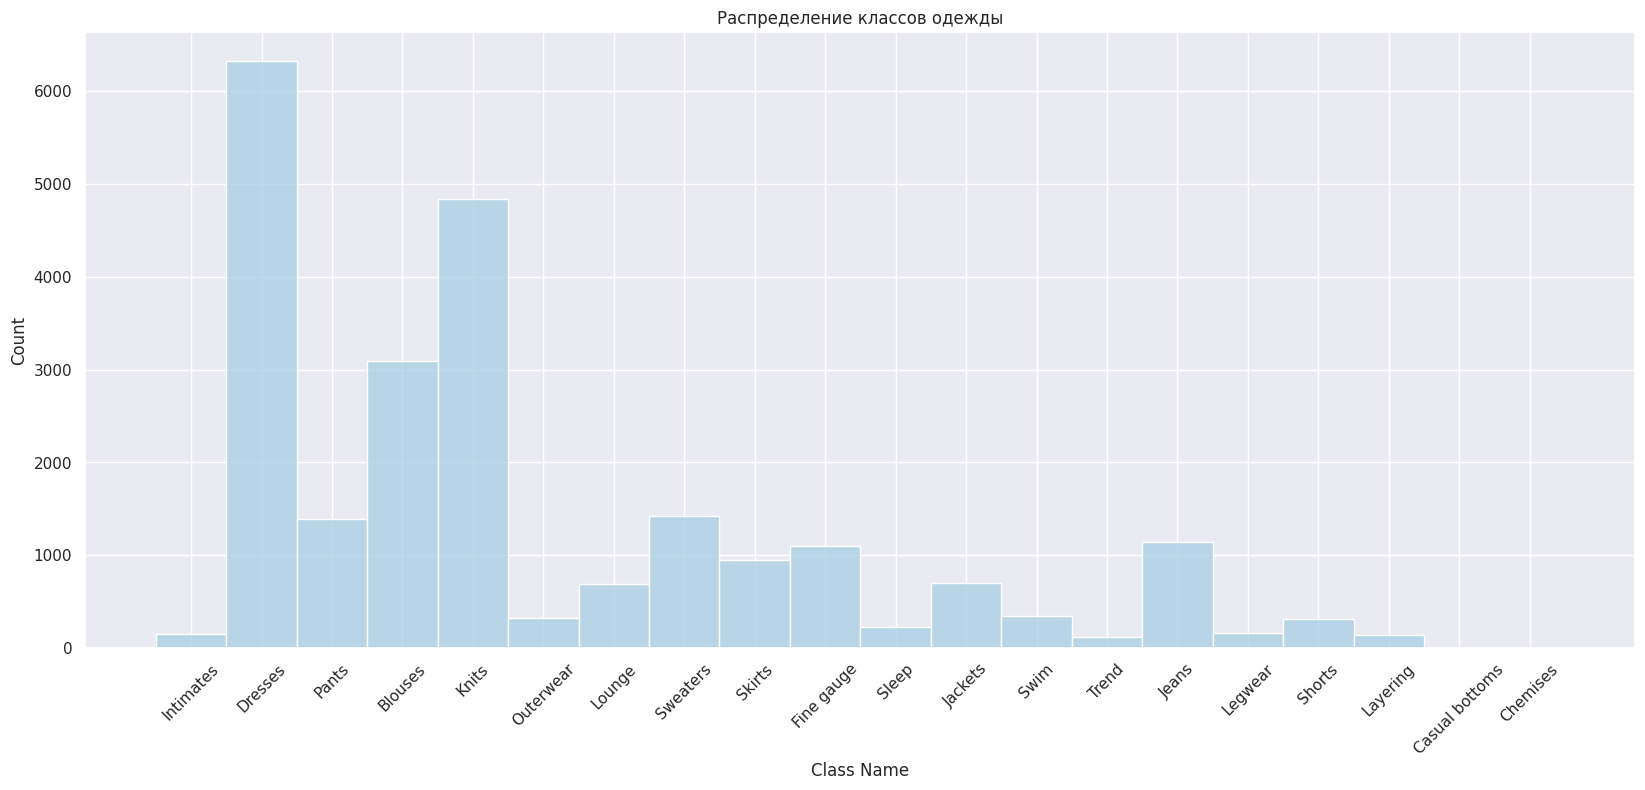

In [14]:
plt.figure(figsize = (20, 8))
sns.histplot(reviews["Class Name"], binwidth=5 ).set_title("Распределение классов одежды");
plt.xticks(rotation=45)
plt.show()


In [8]:
# удаление строк с NaN в колонке 'Review Text'
reviews = reviews[reviews['Review Text'].notna()]
reviews

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


#### длины текстов, на которых будем обучаться

Посмотрим на длины текстов, чтобы в будущем понять какую длину нужно задать векторов при токенизации текстов

In [9]:
# вычисление длин текстов
reviews['review_length'] = reviews['Review Text'].astype('str').apply(lambda x: len(x.split())) # length of post (words)
reviews

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,review_length
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,8
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,62
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,98
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,22
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,36
...,...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses,28
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits,38
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses,42
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses,86


In [17]:
reviews.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,22641.0,11740.849035,6781.957509,0.0,5872.0,11733.0,17621.0,23485.0
Clothing ID,22641.0,919.332362,202.266874,1.0,861.0,936.0,1078.0,1205.0
Age,22641.0,43.280376,12.326980,18.0,34.0,41.0,52.0,99.0
Rating,22641.0,4.183561,1.115762,1.0,4.0,5.0,5.0,5.0
Recommended IND,22641.0,0.818868,0.385136,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,22641.0,2.630582,5.786164,0.0,0.0,1.0,3.0,122.0
review_length,22641.0,60.196679,28.534612,2.0,36.0,59.0,88.0,115.0


Максимальная длина текстов - 115.  
75% текстов - имеют длину 88, можем установить длину в 100 при токенизации

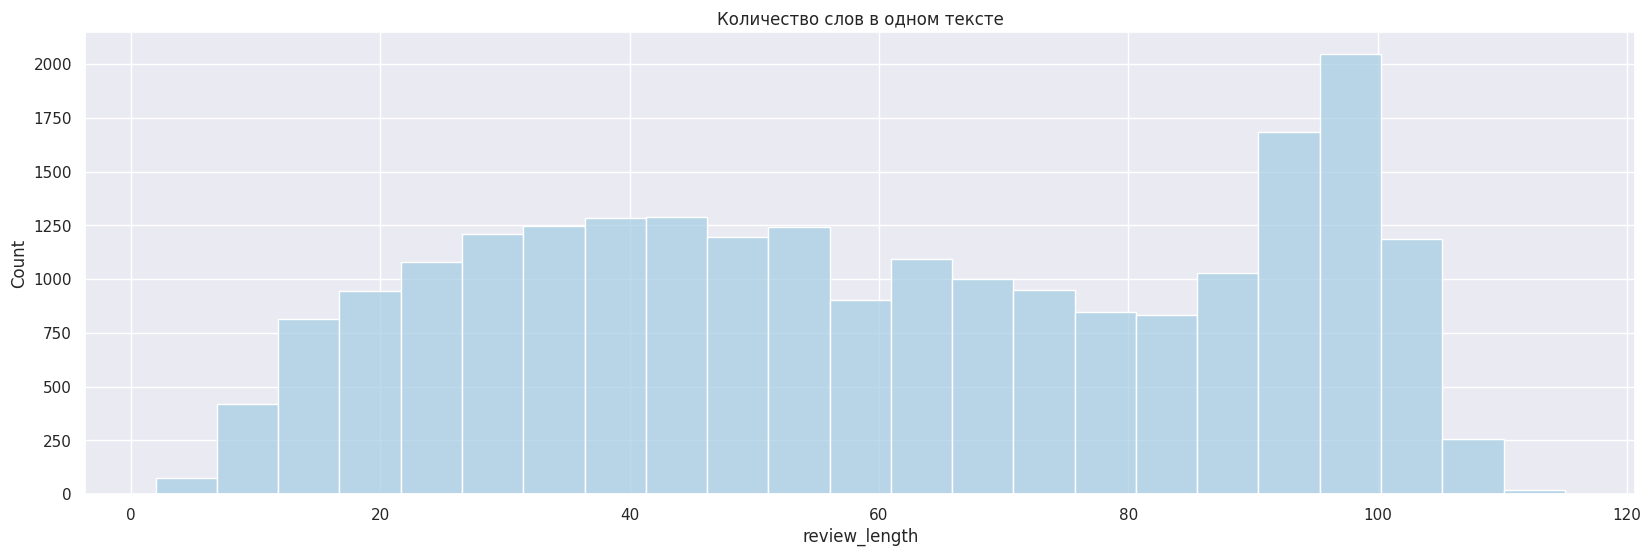

In [18]:
plt.figure(figsize = (20, 6))
sns.histplot(reviews["review_length"], binwidth=5).set_title("Количество слов в одном тексте");

In [19]:
reviews.loc[((reviews['review_length'] == 2))]
# видим, что отзывы из 2-х слов полезны, удаление коротких текстов не требуется

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,review_length
859,859,886,27,NaN,Great style!,5,1,1,General Petite,Tops,Knits,2
1637,1637,992,53,Stunning skirt!,Beautiful colors,5,1,2,General Petite,Bottoms,Skirts,2
2978,2978,1094,35,NaN,Love embroidery!,5,1,0,General,Dresses,Dresses,2
7236,7236,877,41,NaN,Comfy cozy!,4,1,0,General,Tops,Knits,2
7785,7785,820,50,Another beautiful white top,Great fit,5,1,0,General Petite,Tops,Blouses,2
11518,11518,1066,21,Beautiful pant,Great structure,5,1,0,General Petite,Bottoms,Pants,2
13399,13399,927,36,Buy this!,Fits perfect!,5,1,0,General Petite,Tops,Sweaters,2
15653,15653,1089,29,Perfect bride dress,Fits perfect.,5,1,0,General,Dresses,Dresses,2


корреляция

In [20]:
def get_pairplot(X, columns=None):
    if columns is None:
        columns = list(X.columns)
    sns.pairplot(X[columns])
    pass

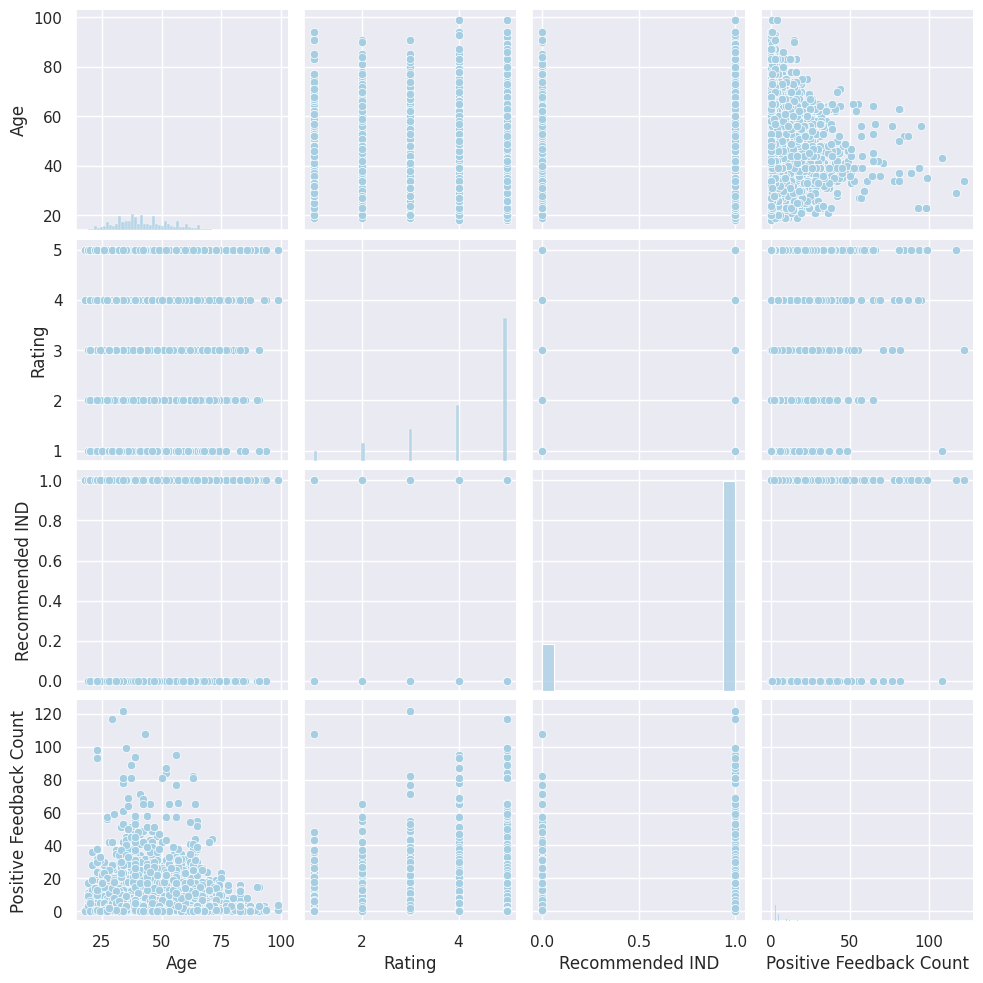

In [23]:
df = reviews[['Age', 'Title', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name']]
get_pairplot(df)

Признаки не коррелируют между собой

### препроцессинг текста

In [24]:
reviews.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'review_length'],
      dtype='object')

#### очищение текста

In [10]:
# возьмем только нужные колонки - текст отзыва, оценка и рейтинг
data = reviews[['Clothing ID', 'Review Text', 'Recommended IND', 'Rating']]
data

,Clothing ID,Review Text,Recommended IND,Rating
0,767,Absolutely wonderful - silky and sexy and comf...,1,4
1,1080,Love this dress! it's sooo pretty. i happene...,1,5
2,1077,I had such high hopes for this dress and reall...,0,3
3,1049,"I love, love, love this jumpsuit. it's fun, fl...",1,5
4,847,This shirt is very flattering to all due to th...,1,5
...,...,...,...,...
23481,1104,I was very happy to snag this dress at such a ...,1,5
23482,862,"It reminds me of maternity clothes. soft, stre...",1,3
23483,1104,"This fit well, but the top was very see throug...",0,3
23484,1084,I bought this dress for a wedding i have this ...,1,3


Проведем очищение текстов от лишних символов - ссылок/пунктуации/повторяющихся пробелов и т.д.

In [11]:
import re
# фукция чистит текст от ссылок, пунктуационных знаков

def clear(df):
    # удаление ссылок
    df["Review Text"] = df["Review Text"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    # удаление пунктуационных знаков
    df["Review Text"] = df["Review Text"].apply(lambda x: re.sub(r'[\.+]', ".",x))
    #удаление повторяющихся пробелов
    df["Review Text"] = df["Review Text"].apply(lambda x: re.sub(r'[^\w\s]','',x))
    #удаление всего, что не относится к буквам
    df["Review Text"] = df["Review Text"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))
     #перевод в нижний регистр
    df["Review Text"] = df["Review Text"].apply(lambda x: x.lower())
    #удаление слов с повторяющимися несколькими буквами подряд
    df["Review Text"] = df["Review Text"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x))
    df["Review Text"] = df["Review Text"].apply(lambda x: x.lstrip().rstrip())


    return df

In [12]:
cleared_df = clear(data)
cleared_df

,Clothing ID,Review Text,Recommended IND,Rating
0,767,absolutely wonderful silky and sexy and comfo...,1,4
1,1080,love this dress its s,1,5
2,1077,i had such high hopes for this dress and reall...,0,3
3,1049,i love love love this jumpsuit its fun flirty ...,1,5
4,847,this shirt is very flattering to all due to th...,1,5
...,...,...,...,...
23481,1104,i was very happy to snag this dress at such a ...,1,5
23482,862,it reminds me of maternity clothes soft stretc...,1,3
23483,1104,this fit well but the top was very see through...,0,3
23484,1084,i bought this dress for a wedding i have this ...,1,3


####  лемматизация

Применим лемматизацию к тестам

In [13]:
# функция приводит слова в нормальную форму
lemmatizer =  nltk.WordNetLemmatizer()
def lemmatize(text):
    try:
        return  " ".join([lemmatizer.lemmatize(w) for w in text.lower().split()])
    except:
        return " "

cleared_df['text'] = cleared_df['Review Text'].astype('str').progress_apply(lemmatize)
cleared_df

  0%|          | 0/22641 [00:00<?, ?it/s]

,Clothing ID,Review Text,Recommended IND,Rating,text
0,767,absolutely wonderful silky and sexy and comfo...,1,4,absolutely wonderful silky and sexy and comfor...
1,1080,love this dress its s,1,5,love this dress it s
2,1077,i had such high hopes for this dress and reall...,0,3,i had such high hope for this dress and really...
3,1049,i love love love this jumpsuit its fun flirty ...,1,5,i love love love this jumpsuit it fun flirty a...
4,847,this shirt is very flattering to all due to th...,1,5,this shirt is very flattering to all due to th...
...,...,...,...,...,...
23481,1104,i was very happy to snag this dress at such a ...,1,5,i wa very happy to snag this dress at such a g...
23482,862,it reminds me of maternity clothes soft stretc...,1,3,it reminds me of maternity clothes soft stretc...
23483,1104,this fit well but the top was very see through...,0,3,this fit well but the top wa very see through ...
23484,1084,i bought this dress for a wedding i have this ...,1,3,i bought this dress for a wedding i have this ...


Посмотрим на

In [29]:
for i in np.random.randint(0, len(reviews), 5):
    print('Ориг:', reviews['Review Text'][i])
    print('Чист:', cleared_df['text'][i], '\n')

Ориг: I don't have the right body to pull this off. too many awkward styling issues (length, slits, tie, stitch quality) so this will have to go back. maybe if i was taller and slimmer this would be good. alas, it isn't meant to be...
Чист: i dont have the right body to pull this off too many awkward styling issue length slit tie stitch quality so this will have to go back maybe if i wa taller and slimmer this would be good ala it isnt meant to be 

Ориг: Fit and flare, pullover style that can easily be dressed up or down. wish other colors were available online!
Чист: fit and flare pullover style that can easily be dressed up or down wish other color were available online 

Ориг: Wanted to buy this dress, but the bust area was way too small. as i went up sizes, the torso began to be too long, and i would have to have it altered, i guess. what a shame.
but, if you are small chested, then this is your dress.
Чист: wanted to buy this dress but the bust area wa way too small a i went up s

Подготовим для отдельных датасета для двух циклов обучения.
Первый - для бинарной классификации  отзыва (положительного или отрицательного)
Второй для классификации по рейтингу

In [14]:
# датасет для бинарной классификации
dataset_1 = cleared_df[['text']]
dataset_1['label'] = cleared_df['Recommended IND']
dataset_1

,text,label
0,absolutely wonderful silky and sexy and comfor...,1
1,love this dress it s,1
2,i had such high hope for this dress and really...,0
3,i love love love this jumpsuit it fun flirty a...,1
4,this shirt is very flattering to all due to th...,1
...,...,...
23481,i wa very happy to snag this dress at such a g...,1
23482,it reminds me of maternity clothes soft stretc...,1
23483,this fit well but the top wa very see through ...,0
23484,i bought this dress for a wedding i have this ...,1


In [15]:
# датасет для классификации по рейтингу
dataset_2 = cleared_df[['text']]
dataset_2['label'] = cleared_df['Rating']
dataset_2

,text,label
0,absolutely wonderful silky and sexy and comfor...,4
1,love this dress it s,5
2,i had such high hope for this dress and really...,3
3,i love love love this jumpsuit it fun flirty a...,5
4,this shirt is very flattering to all due to th...,5
...,...,...
23481,i wa very happy to snag this dress at such a g...,5
23482,it reminds me of maternity clothes soft stretc...,3
23483,this fit well but the top wa very see through ...,3
23484,i bought this dress for a wedding i have this ...,3


In [16]:
# Сохранение датасетов в csv файл для дальнейшего использования
dataset_1.to_csv('dataset_1.csv', index=False)
dataset_2.to_csv('dataset_2.csv', index=False)

### конвейер обучения

In [17]:
# фиксация стэйта
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch(42)

#### Задача бинарной классификации Recommended IND

##### токенизация

In [6]:
# датасет для бинарной классификации
full_dataset_1 = load_dataset('csv', data_files='dataset_1.csv')
# Фильтрация записей, в которых текстовые поля или метки не являются None
full_dataset_1 = full_dataset_1.filter(lambda example: example['text'] is not None and example['label'] is not None)

full_dataset_1

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/22641 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 22639
    })
})

In [7]:
# разделим на обучающую и тестовую
dataset = full_dataset_1['train'].train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 18111
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4528
    })
})

In [8]:
dataset['train'][0]

{'text': 'this dress is my first retailer purchase in several year i saw it in the window and had to try it on im quite small usually a size at most and b at the top i had to size up to a in this dress for it to zip up and be moderately comfortable i love the s vibe of the volume at the bottom the cotton is nice glad to see retailer go back to offering natural fabric very pretty color and print',
 'label': 1}

In [4]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch

model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [39]:
# токенизация текста
dataset = dataset.map(lambda e:
                      tokenizer(e['text'],
                                truncation = True,
                                max_length=110,
                                padding='max_length'), batched=True)

Map:   0%|          | 0/18111 [00:00<?, ? examples/s]

Map:   0%|          | 0/4528 [00:00<?, ? examples/s]

In [40]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 18111
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4528
    })
})

In [41]:
# текст был успешно закодирован, более он нам не нужен
dataset = dataset.remove_columns('text')

In [42]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 18111
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 4528
    })
})

In [43]:
# переносим на гпу
dataset.set_format(type='torch')
# model.to(device)

In [44]:
dataset['train'][0]

{'label': tensor(1),
 'input_ids': tensor([  101,  2023,  4377,  2003,  2026,  2034, 20196,  5309,  1999,  2195,
          2095,  1045,  2387,  2009,  1999,  1996,  3332,  1998,  2018,  2000,
          3046,  2009,  2006, 10047,  3243,  2235,  2788,  1037,  2946,  2012,
          2087,  1998,  1038,  2012,  1996,  2327,  1045,  2018,  2000,  2946,
          2039,  2000,  1037,  1999,  2023,  4377,  2005,  2009,  2000, 14101,
          2039,  1998,  2022, 17844,  6625,  1045,  2293,  1996,  1055, 21209,
          1997,  1996,  3872,  2012,  1996,  3953,  1996,  6557,  2003,  3835,
          5580,  2000,  2156, 20196,  2175,  2067,  2000,  5378,  3019,  8313,
          2200,  3492,  3609,  1998,  6140,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

##### запуск обучения

In [45]:
# тест модели
outputs = model(dataset['train']['input_ids'][0].unsqueeze(0).to(device), dataset['train']['attention_mask'][0].unsqueeze(0).to(device), dataset['train']['label'][0].unsqueeze(0).to(device))
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0152,  0.0367]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [46]:
from transformers import Trainer, TrainingArguments
from datasets import load_metric

# Загрузка метрики вне функции
metric_f1 = load_metric("f1")

# Параметры обучения
training_args = TrainingArguments(
        output_dir="./results",  # Каталог для сохранения результатов обучения
        num_train_epochs=4,  # Количество эпох обучения
        per_device_train_batch_size=8,  # Размер батча для обучения
        per_device_eval_batch_size=8,  # Размер батча для валидации
        learning_rate = 1e-4,
        warmup_steps=500,  # Количество шагов разогрева
        weight_decay=0.01,  # Сила L2 регуляризации
        # logging_dir="./runs",  # Каталог для логов TensorBoard
        # logging_steps=500,  # Логирование каждые 500 шагов
        evaluation_strategy="epoch",  # Стратегия оценки
        save_strategy="epoch",  # Стратегия сохранения модели
        load_best_model_at_end=True,  # Загрузка лучшей модели в конце
        metric_for_best_model="f1",  # Метрика для выбора лучшей модели
        greater_is_better=True,  # Указывает, что большее значение метрики лучше
        remove_unused_columns=False)

# Функция для вычисления метрик
def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        f1 = metric_f1.compute(predictions=predictions, references=labels, average='binary')
        return f1

trainer = Trainer(
    model=model,  # Модель для обучения
    args=training_args,  # Аргументы обучения
    train_dataset=dataset["train"],  # Набор данных для обучения
    eval_dataset=dataset["test"],  # Набор данных для валидации
    compute_metrics=compute_metrics,  # Метрики для вычисления
)

The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [47]:
# Запускаем обучение
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.307400,0.328134,0.934308
2,0.258400,0.311051,0.933224
3,0.216800,0.410308,0.937091
4,0.148300,0.399502,0.941005


TrainOutput(global_step=9056, training_loss=0.23743527079850119, metrics={'train_runtime': 998.9875, 'train_samples_per_second': 72.517, 'train_steps_per_second': 9.065, 'total_flos': 2061741220909920.0, 'train_loss': 0.23743527079850119, 'epoch': 4.0})

##### результаты и выводы

In [48]:
res_1 = pd.DataFrame(trainer.state.log_history)
res_1 = res_1.fillna(0)

In [20]:
def result(res):
    e_loss = []
    e_f1 = []
    t_loss = []

    for el in res['eval_loss'].values:
        if el != 0:
            e_loss.append(el)
    for el in res['eval_f1'].values:
        if el != 0:
            e_f1.append(el)
    for el in res['loss'].values:
        if el != 0:
            t_loss.append(el)

    plot_graph(e_loss, t_loss, e_f1)

def plot_graph(e_loss,t_loss, e_f1):
    plt.figure(figsize=(17, 5))

    plt.subplot(1, 3, 1)
    # plt.plot(np.arange(len(e_loss)), e_loss, t_loss)
    plt.plot(np.arange(len(t_loss)), t_loss, label = 'train', color='red')
    plt.title('Train Loss')
    plt.xlabel("epoch")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(np.arange(len(e_loss)), e_loss, label = 'eval', color='blue')
    plt.title('Eval Loss')
    plt.xlabel("epoch")
    plt.legend()


    plt.subplot(1, 3, 3)
    plt.plot(np.arange(len(e_f1)), e_f1, color='green')
    plt.title('Eval F1')
    plt.xlabel("epoch")

    plt.show()

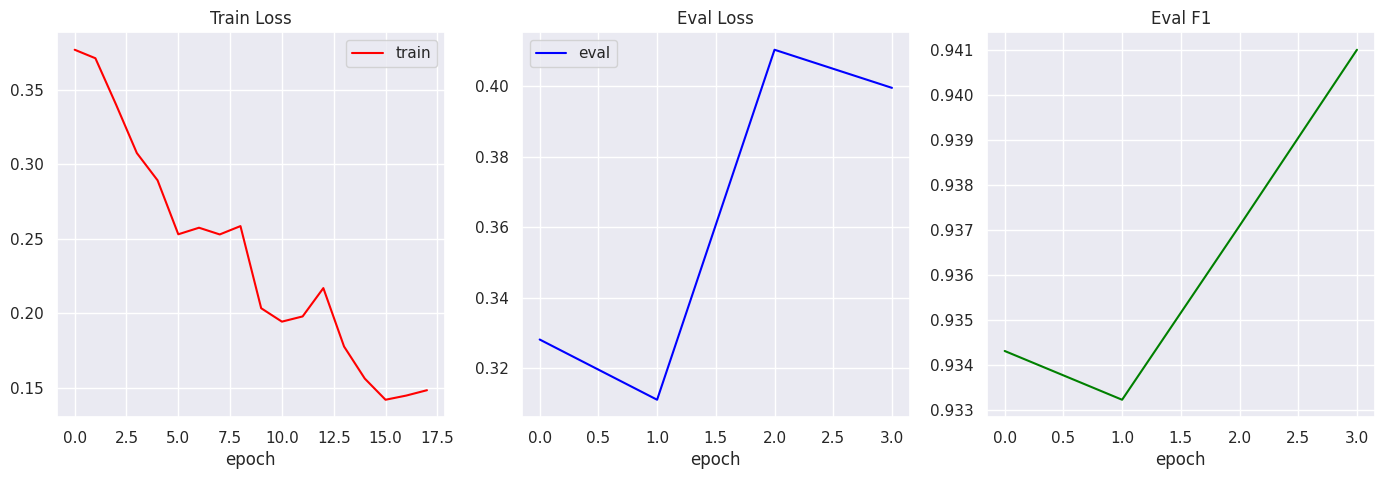

In [50]:
result(res_1)

Выводы по графикам: на тренировке модель показывает себя хорошо, функция потерь падает, обучение происходит, на валидации ситуация чуть похуже, функция потерь скачет, то падает, то возрастает, на начальном этапе обучения, что не сильно критично.

#### Задача прогноз рейтинга (Rating)

##### токенизация

In [9]:
model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
# датасет для многоклассовой классификации по рейтингу
full_dataset_2 = load_dataset('csv', data_files='dataset_2.csv')
# Фильтрация записей, в которых текстовые поля или метки не являются None
full_dataset_2 = full_dataset_2.filter(lambda example: example['text'] is not None and example['label'] is not None)

full_dataset_2

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 22639
    })
})

In [23]:
# разделим на обучающую и тестовую
dataset = full_dataset_2['train'].train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 18111
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4528
    })
})

In [11]:
dataset['train'][0]

{'text': 'this dress is my first retailer purchase in several year i saw it in the window and had to try it on im quite small usually a size at most and b at the top i had to size up to a in this dress for it to zip up and be moderately comfortable i love the s vibe of the volume at the bottom the cotton is nice glad to see retailer go back to offering natural fabric very pretty color and print',
 'label': 1}

In [12]:
dataset = dataset.map(lambda e:
                      tokenizer(e['text'],
                                truncation = True,
                                max_length=110,
                                padding='max_length'), batched=True)

Map:   0%|          | 0/18111 [00:00<?, ? examples/s]

Map:   0%|          | 0/4528 [00:00<?, ? examples/s]

In [13]:
dataset.set_format(type='torch')

In [14]:
# инициализируем модель на классификацию на 5 классов
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

#### запуск обучения

In [18]:
from transformers import Trainer, TrainingArguments
from datasets import load_metric

# Загрузка метрики вне функции
metric_f1 = load_metric("f1")

# Параметры обучения
training_args = TrainingArguments(
        output_dir="./results",  # Каталог для сохранения результатов обучения
        num_train_epochs=4,  # Количество эпох обучения
        per_device_train_batch_size=8,  # Размер батча для обучения
        per_device_eval_batch_size=8,  # Размер батча для валидации
        learning_rate = 1e-4,
        warmup_steps=500,  # Количество шагов разогрева
        weight_decay=0.01,  # Сила L2 регуляризации
        # logging_dir="./runs",  # Каталог для логов TensorBoard
        # logging_steps=500,  # Логирование каждые 500 шагов
        evaluation_strategy="epoch",  # Стратегия оценки
        save_strategy="epoch",  # Стратегия сохранения модели
        load_best_model_at_end=True,  # Загрузка лучшей модели в конце
        metric_for_best_model="f1",  # Метрика для выбора лучшей модели
        greater_is_better=True,  # Указывает, что большее значение метрики лучше
        remove_unused_columns=False)

# Функция для вычисления метрик
def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        f1 = metric_f1.compute(predictions=predictions, references=labels, average='weighted')
        return f1

trainer = Trainer(
    model=model,  # Модель для обучения
    args=training_args,  # Аргументы обучения
    train_dataset=dataset["train"],  # Набор данных для обучения
    eval_dataset=dataset["test"],  # Набор данных для валидации
    compute_metrics=compute_metrics,  # Метрики для вычисления
)

In [19]:
# Запускаем обучение
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.297700,0.305093,0.890714
2,0.267800,0.323525,0.892456
3,0.189600,0.392616,0.898119
4,0.127300,0.448946,0.895632


TrainOutput(global_step=9056, training_loss=0.23486863640087655, metrics={'train_runtime': 962.014, 'train_samples_per_second': 75.305, 'train_steps_per_second': 9.414, 'total_flos': 2061851525593200.0, 'train_loss': 0.23486863640087655, 'epoch': 4.0})

##### результаты и выводы

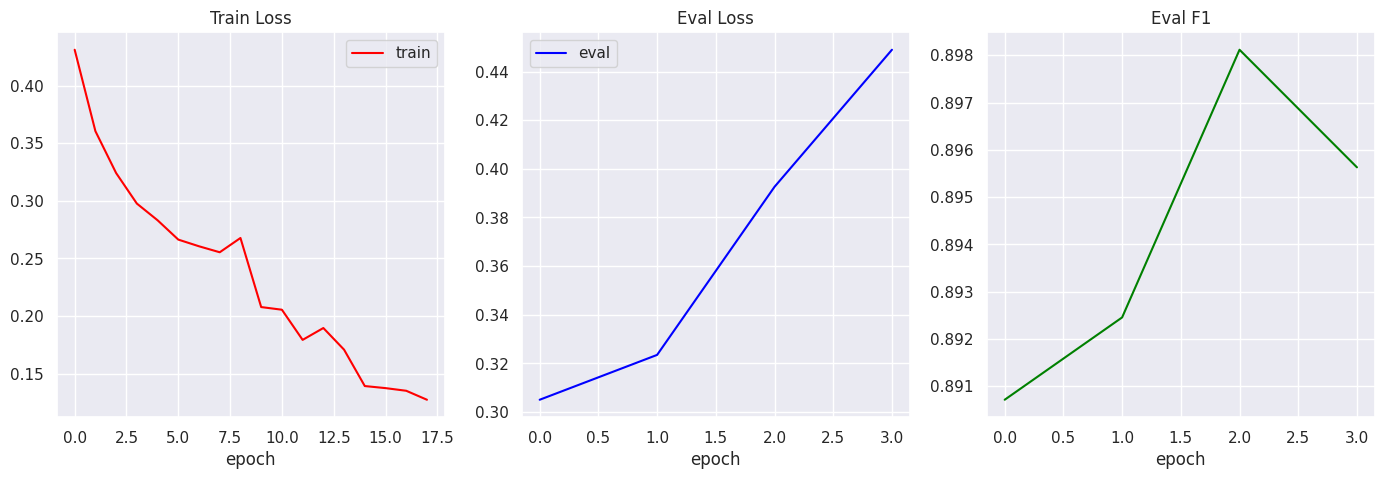

In [21]:
res_2 = pd.DataFrame(trainer.state.log_history)
res_2 = res_2.fillna(0)
result(res_2)

Выводы по графикам: метрика растет, что хорошо. Функция потерь на тренировке равномерно падает, на валидации наоборот, возможно переобучение. Можно попробоватьизменить lr, чтобы стабилизировать результат.

Уменьшим LR => learning_rate = 1e-6

In [29]:
from transformers import Trainer, TrainingArguments
from datasets import load_metric

# Загрузка метрики вне функции
metric_f1 = load_metric("f1")

# Параметры обучения
training_args = TrainingArguments(
        output_dir="./results",  # Каталог для сохранения результатов обучения
        num_train_epochs=4,  # Количество эпох обучения
        per_device_train_batch_size=8,  # Размер батча для обучения
        per_device_eval_batch_size=8,  # Размер батча для валидации
        learning_rate = 1e-6,
        warmup_steps=500,  # Количество шагов разогрева
        weight_decay=0.01,  # Сила L2 регуляризации
        # logging_dir="./runs",  # Каталог для логов TensorBoard
        # logging_steps=500,  # Логирование каждые 500 шагов
        evaluation_strategy="epoch",  # Стратегия оценки
        save_strategy="epoch",  # Стратегия сохранения модели
        load_best_model_at_end=True,  # Загрузка лучшей модели в конце
        metric_for_best_model="f1",  # Метрика для выбора лучшей модели
        greater_is_better=True,  # Указывает, что большее значение метрики лучше
        remove_unused_columns=False)

# Функция для вычисления метрик
def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        f1 = metric_f1.compute(predictions=predictions, references=labels, average='weighted')
        return f1

trainer = Trainer(
    model=model,  # Модель для обучения
    args=training_args,  # Аргументы обучения
    train_dataset=dataset["train"],  # Набор данных для обучения
    eval_dataset=dataset["test"],  # Набор данных для валидации
    compute_metrics=compute_metrics,  # Метрики для вычисления
)

In [30]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [31]:
# Запускаем обучение
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.355000,0.310298,0.870613
2,0.290000,0.286582,0.885580
3,0.264300,0.290733,0.890614
4,0.273000,0.295658,0.890323


TrainOutput(global_step=9056, training_loss=0.3583595478913809, metrics={'train_runtime': 979.319, 'train_samples_per_second': 73.974, 'train_steps_per_second': 9.247, 'total_flos': 2061851525593200.0, 'train_loss': 0.3583595478913809, 'epoch': 4.0})

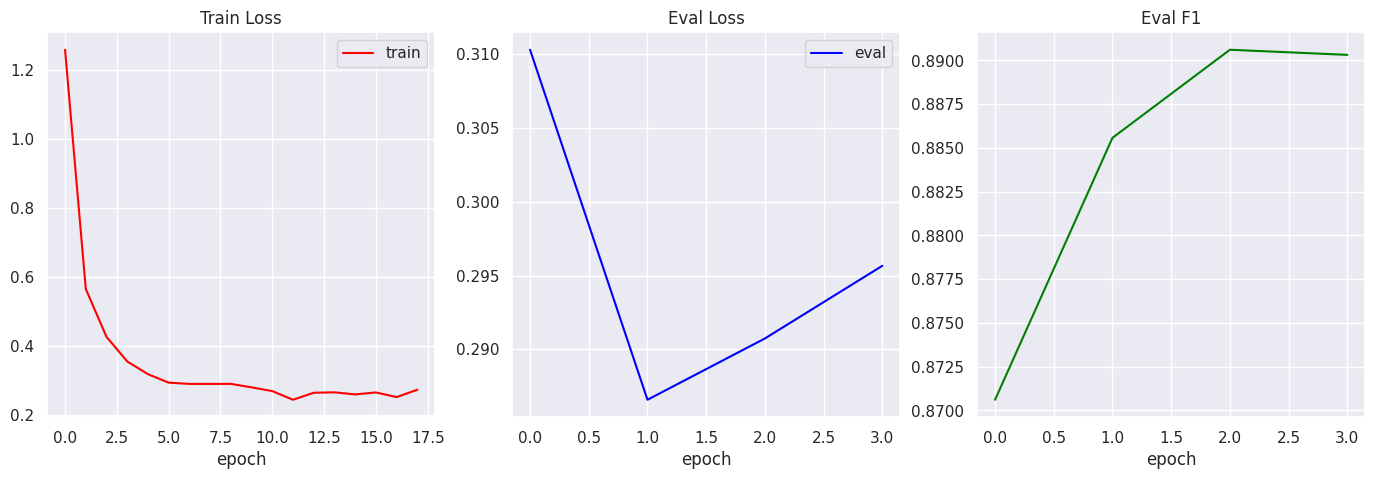

In [32]:
res_3 = pd.DataFrame(trainer.state.log_history)
res_3 = res_3.fillna(0)
result(res_3)

Вывод: после уменьшения learning_rate обучение выглядит более стабильным и правильным.